In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
from scipy.linalg import qr_insert, qr

In [3]:
from desc import set_device
set_device("gpu")

from desc.basis import *
from desc.backend import *
from desc.compute import data_index
from desc.coils import SplineXYZCoil
from desc.equilibrium import *
from desc.examples import get
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import factorize_linear_constraints
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import Optimizer
from desc.perturbations import *
from desc.profiles import PowerSeriesProfile

from desc.utils import copy_coeffs, svd_inv_null

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

DESC version 0.12.3+460.g8e9be76b8.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory


In [4]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [5]:
def solve_step(eq_poin, maxiter=100, plot=False, **kwargs):
    R_modes = eq_poin.R_basis.modes[eq_poin.R_basis.modes[:, 2] == 0][:,:2]
    Z_modes = eq_poin.Z_basis.modes[eq_poin.Z_basis.modes[:, 2] == 0][:,:2]
    
    cons = get_fixed_boundary_constraints(eq_poin)
    cons += (
        FixSectionLambda(eq_poin),
        FixSectionR(eq_poin),
        FixSectionZ(eq_poin),
        FixAxisR(eq_poin),
        FixAxisZ(eq_poin),
        FixModeR(eq_poin, modes=R_modes),
        FixModeZ(eq_poin, modes=Z_modes),
    )
    obj = ObjectiveFunction(ForceBalance(eq_poin))
    eq_poin.solve(constraints=cons, objective=obj, maxiter=maxiter, verbose=3, **kwargs);
    if plot:
        plot_comparison(eqs=[eq, eq_poin], labels=["original", "only axisymmetric"]); 

In [6]:
def get_n0_eq(eq):
    R_modes = eq.R_basis.modes[eq.R_basis.modes[:, 2] == 0][:,:2]
    R_lmn = eq.R_lmn[eq.R_basis.modes[:, 2] == 0]

    Z_modes = eq.Z_basis.modes[eq.Z_basis.modes[:, 2] == 0][:,:2]
    Z_lmn = eq.Z_lmn[eq.Z_basis.modes[:, 2] == 0]

    L_modes = Z_modes
    L_lmn = np.zeros_like(Z_lmn)

    section = ZernikeRZLToroidalSection(
        modes_R=R_modes,
        R_lmn=R_lmn,
        modes_Z=Z_modes,
        Z_lmn=Z_lmn,
        modes_L=L_modes,
        L_lmn=L_lmn,
    )

    eq_n0 = Equilibrium(
        xsection=section,
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )
    
    return eq_n0

In [13]:
eq0 = get("HELIOTRON")
eq = eq0.copy()
eq_poincare = get_n0_eq(eq)

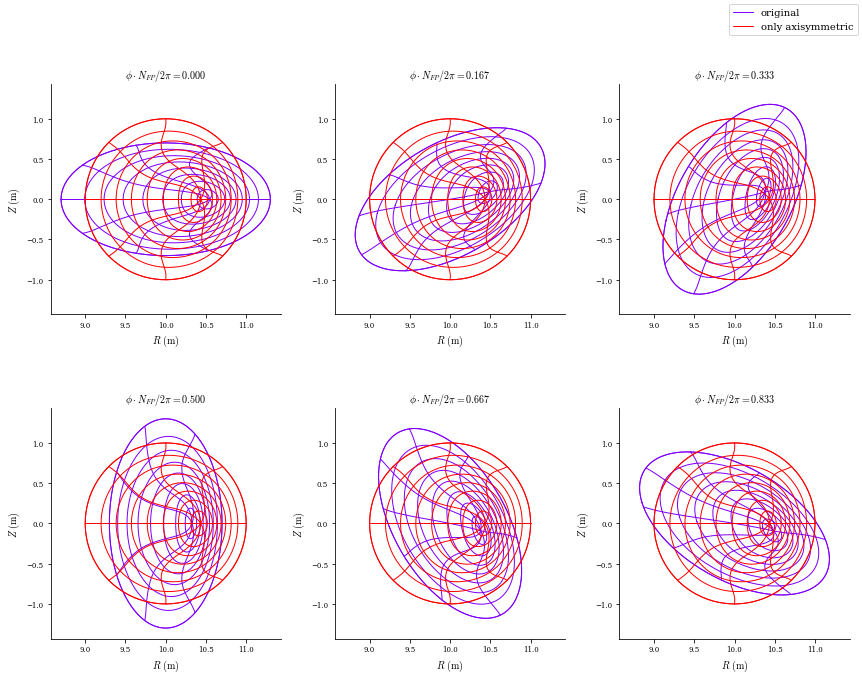

In [14]:
plot_comparison(eqs=[eq0, eq_poincare], labels=["original", "only axisymmetric"]);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 94.6 ms
Timer: Objective build = 109 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 302 ms
Timer: Linear constraint projection build = 603 ms
Number of parameters: 1599
Number of objectives: 4940
Timer: Initializing the optimization = 1.03 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.032e+00                                    1.114e+01   
       

      170            210         3.259e-06      2.958e-08      2.185e-03      1.297e-02   
      171            211         3.232e-06      2.710e-08      4.196e-03      3.453e-02   
      172            213         3.203e-06      2.958e-08      2.263e-03      1.132e-02   
      173            214         3.174e-06      2.816e-08      4.372e-03      3.012e-02   
      174            216         3.145e-06      2.949e-08      2.353e-03      9.921e-03   
      175            217         3.116e-06      2.919e-08      4.558e-03      2.664e-02   
      176            219         3.086e-06      2.952e-08      2.443e-03      8.527e-03   
      177            220         3.056e-06      3.009e-08      4.741e-03      2.516e-02   
      178            222         3.026e-06      2.967e-08      2.529e-03      7.140e-03   
      179            223         2.996e-06      3.083e-08      4.912e-03      2.671e-02   
      180            225         2.966e-06      2.990e-08      2.607e-03      5.766e-03   

      350            411         6.553e-07      7.165e-09      3.645e-03      6.793e-02   
      351            412         6.479e-07      7.347e-09      3.640e-03      7.175e-02   
      352            413         6.404e-07      7.527e-09      3.633e-03      7.545e-02   
      353            414         6.327e-07      7.704e-09      3.622e-03      7.901e-02   
      354            415         6.248e-07      7.879e-09      3.608e-03      8.244e-02   
      355            416         6.168e-07      8.051e-09      3.591e-03      8.573e-02   
      356            417         6.085e-07      8.221e-09      3.571e-03      8.886e-02   
      357            418         6.001e-07      8.390e-09      3.548e-03      9.181e-02   
      358            419         5.916e-07      8.560e-09      3.521e-03      9.453e-02   
      359            420         5.829e-07      8.732e-09      3.491e-03      9.697e-02   
      360            421         5.740e-07      8.905e-09      3.456e-03      9.903e-02   

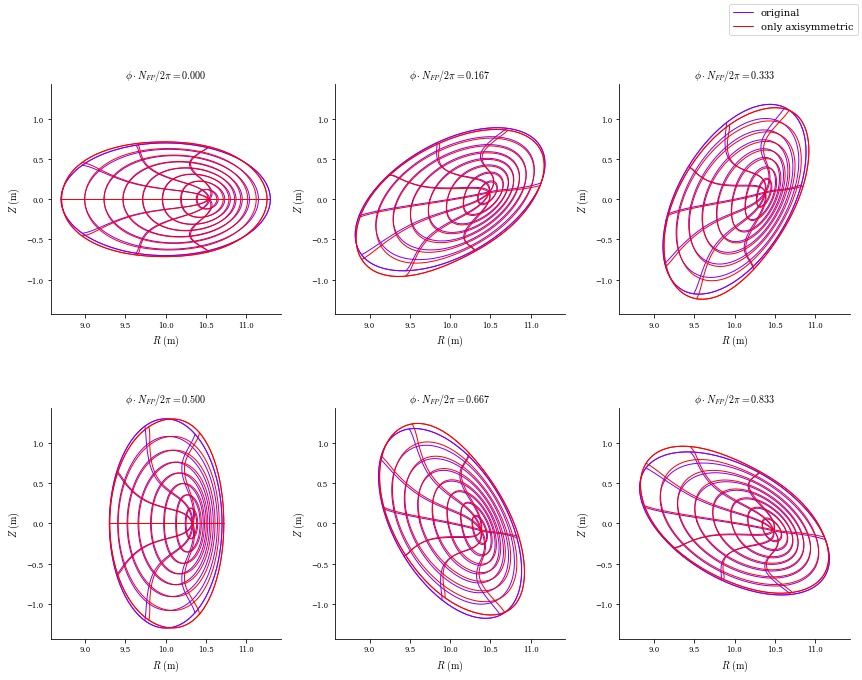

In [15]:
solve_step(eq_poincare, maxiter= 500, plot=True, ftol=0, gtol=0, xtol=0)

In [24]:
def solve_step_volume(eq_poin, maxiter=100, plot=False, **kwargs):
    R_modes = eq_poin.R_basis.modes[eq_poin.R_basis.modes[:, 2] == 0][:,:2]
    Z_modes = eq_poin.Z_basis.modes[eq_poin.Z_basis.modes[:, 2] == 0][:,:2]
    
    cons = get_fixed_boundary_constraints(eq_poin)
    cons += (
        FixSectionLambda(eq_poin),
        FixSectionR(eq_poin),
        FixSectionZ(eq_poin),
        FixAxisR(eq_poin),
        FixAxisZ(eq_poin),
        FixModeR(eq_poin, modes=R_modes),
        FixModeZ(eq_poin, modes=Z_modes),
        Volume(eq_poin, target=volume),
    )
    obj = ObjectiveFunction(ForceBalance(eq_poin))
    eq_poin.solve(constraints=cons, objective=obj, maxiter=maxiter, verbose=3, **kwargs);
    if plot:
        plot_comparison(eqs=[eq, eq_poin], labels=["original", "only axisymmetric"]); 

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 97.3 ms
Timer: Objective build = 114 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 371 ms
Building objective: volume
Precomputing transforms
Timer: Precomputing transforms = 53.4 ms
Timer: Objective build = 67.4 ms
Timer: Linear constraint projection build = 598 ms
Timer: Linear constraint projection build = 596 ms
Number of parameters: 1599
Number of objectives: 4940
Number of equality constraints: 1
Number of inequality constraints: 0
Timer: Initializing the optimization =

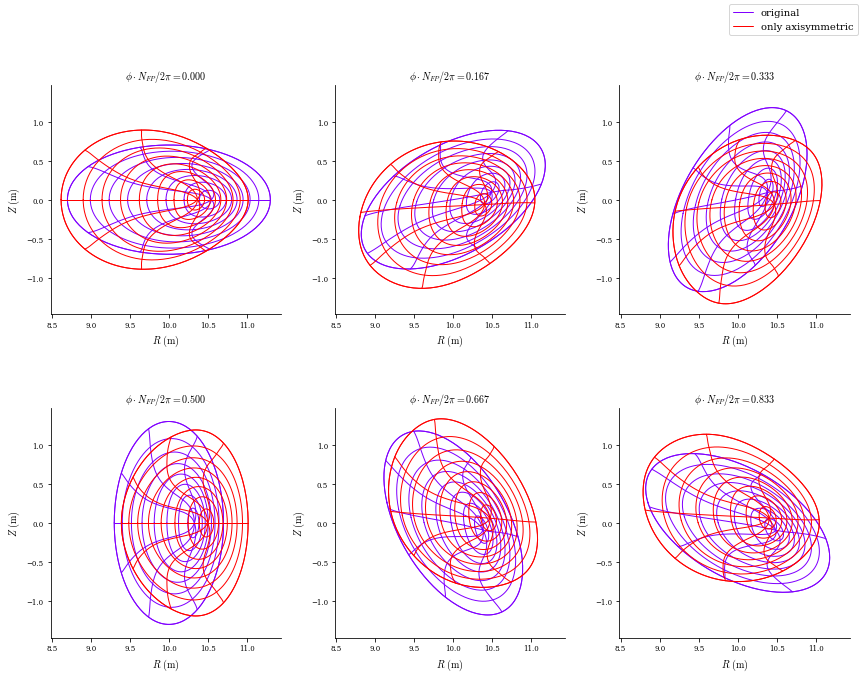

In [27]:
optimizer = Optimizer("lsq-auglag")
solve_step_volume(eq_poincare, maxiter=200, plot=True, optimizer=optimizer)

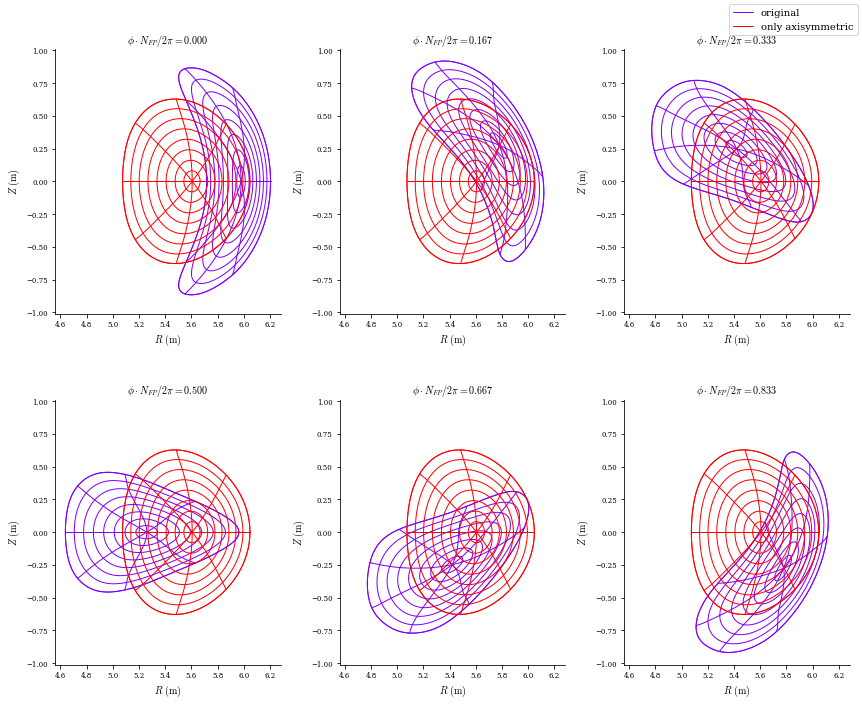

In [8]:
eq = get("W7-X")
eq_poincare = get_n0_eq(eq)
plot_comparison(eqs=[eq, eq_poincare], labels=["original", "only axisymmetric"]);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 797 ms
Timer: Objective build = 1.15 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 969 ms
Timer: Linear constraint projection build = 12.7 sec
Number of parameters: 6162
Number of objectives: 10098
Timer: Initializing the optimization = 14.9 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.231e-01                                    1.915e+00   
   

      80             87          1.377e-08      6.486e-10      3.389e-03      1.599e-02   
      81             88          1.315e-08      6.245e-10      3.318e-03      1.547e-02   
      82             89          1.255e-08      6.010e-10      3.248e-03      1.499e-02   
      83             90          1.197e-08      5.781e-10      3.179e-03      1.454e-02   
      84             91          1.141e-08      5.559e-10      3.112e-03      1.412e-02   
      85             92          1.088e-08      5.343e-10      3.046e-03      1.371e-02   
      86             93          1.036e-08      5.134e-10      2.983e-03      1.330e-02   
      87             94          9.872e-09      4.931e-10      2.921e-03      1.287e-02   
      88             95          9.398e-09      4.734e-10      2.862e-03      1.258e-02   
      89             96          8.944e-09      4.543e-10      2.806e-03      1.253e-02   
      90             97          8.508e-09      4.358e-10      2.752e-03      1.260e-02   

      170            177         3.508e-10      4.371e-12      1.032e-03      3.649e-03   
      171            178         3.466e-10      4.266e-12      1.037e-03      3.607e-03   
      172            179         3.424e-10      4.166e-12      1.041e-03      3.575e-03   
      173            180         3.383e-10      4.069e-12      1.045e-03      3.558e-03   
      174            181         3.344e-10      3.977e-12      1.048e-03      3.559e-03   
      175            182         3.305e-10      3.889e-12      1.051e-03      3.583e-03   
      176            183         3.267e-10      3.804e-12      1.053e-03      3.632e-03   
      177            184         3.229e-10      3.720e-12      1.054e-03      3.726e-03   
      178            185         3.193e-10      3.638e-12      1.056e-03      3.853e-03   
      179            186         3.157e-10      3.558e-12      1.057e-03      3.988e-03   
      180            187         3.123e-10      3.480e-12      1.058e-03      4.126e-03   

      260            271         1.775e-10      7.714e-13      4.970e-04      6.299e-04   
      261            273         1.770e-10      5.833e-13      2.476e-04      1.538e-04   
      262            274         1.764e-10      5.606e-13      4.961e-04      5.671e-04   
      263            275         1.756e-10      7.537e-13      4.953e-04      5.315e-04   
      264            277         1.751e-10      5.659e-13      2.467e-04      1.296e-04   
      265            278         1.745e-10      5.521e-13      4.943e-04      4.806e-04   
      266            279         1.738e-10      7.370e-13      4.935e-04      4.506e-04   
      267            281         1.732e-10      5.508e-13      2.458e-04      1.098e-04   
      268            282         1.727e-10      5.428e-13      4.924e-04      4.094e-04   
      269            283         1.720e-10      7.212e-13      4.916e-04      3.840e-04   
      270            285         1.714e-10      5.376e-13      2.448e-04      9.346e-05   

      350            391         1.338e-10      4.321e-13      4.443e-04      2.417e-04   
      351            393         1.335e-10      3.357e-13      2.206e-04      6.149e-05   
      352            394         1.332e-10      3.056e-13      4.432e-04      2.422e-04   
      353            395         1.327e-10      4.228e-13      4.423e-04      2.449e-04   
      354            397         1.324e-10      3.321e-13      2.196e-04      6.270e-05   
      355            398         1.321e-10      2.954e-13      4.411e-04      2.454e-04   
      356            399         1.317e-10      4.138e-13      4.401e-04      2.494e-04   
      357            401         1.314e-10      3.290e-13      2.185e-04      6.391e-05   
      358            402         1.311e-10      2.851e-13      4.388e-04      2.498e-04   
      359            403         1.307e-10      4.051e-13      4.377e-04      2.537e-04   
      360            405         1.304e-10      3.262e-13      2.173e-04      6.506e-05   

      440            486         1.066e-10      2.249e-13      4.208e-04      3.243e-04   
      441            487         1.063e-10      2.235e-13      4.211e-04      3.220e-04   
      442            488         1.061e-10      2.222e-13      4.214e-04      3.192e-04   
      443            489         1.059e-10      2.208e-13      4.217e-04      3.159e-04   
      444            490         1.057e-10      2.195e-13      4.219e-04      3.121e-04   
      445            491         1.054e-10      2.182e-13      4.221e-04      3.077e-04   
      446            492         1.052e-10      2.169e-13      4.223e-04      3.029e-04   
      447            493         1.050e-10      2.156e-13      4.225e-04      2.976e-04   
      448            494         1.048e-10      2.143e-13      4.226e-04      2.919e-04   
      449            495         1.046e-10      2.130e-13      4.227e-04      2.857e-04   
      450            496         1.044e-10      2.118e-13      4.228e-04      2.792e-04   

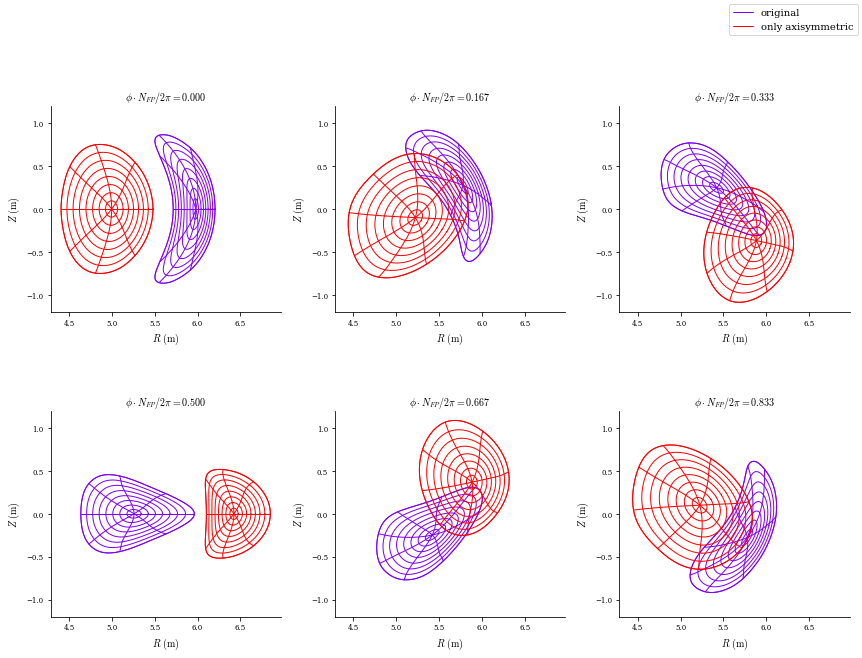

In [9]:
solve_step(eq_poincare, maxiter= 500, plot=True, ftol=0, gtol=0, xtol=0)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 137 ms
Timer: Objective build = 157 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: fixed cross-section λ
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed axis R
Building objective: fixed axis Z
Building objective: fix mode R
Building objective: fix mode Z
Timer: Objective build = 355 ms
Timer: Linear constraint projection build = 6.53 sec
Number of parameters: 6162
Number of objectives: 10098
Timer: Initializing the optimization = 7.08 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          9.506e-11                                    3.402e-04   
     

      80             106         8.798e-11      6.584e-14      2.651e-04      1.874e-04   
      81             107         8.789e-11      9.498e-14      2.658e-04      1.916e-04   
      82             109         8.781e-11      7.663e-14      1.324e-04      4.881e-05   
      83             110         8.775e-11      6.522e-14      2.669e-04      1.935e-04   
      84             111         8.765e-11      9.409e-14      2.676e-04      1.973e-04   
      85             113         8.758e-11      7.595e-14      1.333e-04      5.033e-05   
      86             114         8.751e-11      6.459e-14      2.686e-04      1.984e-04   
      87             115         8.742e-11      9.322e-14      2.693e-04      2.019e-04   
      88             117         8.734e-11      7.529e-14      1.341e-04      5.159e-05   
      89             118         8.728e-11      6.396e-14      2.703e-04      2.023e-04   
      90             119         8.719e-11      9.237e-14      2.710e-04      2.055e-04   

      170            226         8.166e-11      5.352e-14      2.919e-04      1.579e-04   
      171            227         8.159e-11      7.447e-14      2.918e-04      1.580e-04   
      172            229         8.153e-11      5.802e-14      1.449e-04      4.078e-05   
      173            230         8.148e-11      5.339e-14      2.916e-04      1.539e-04   
      174            231         8.140e-11      7.395e-14      2.914e-04      1.540e-04   
      175            233         8.135e-11      5.738e-14      1.447e-04      3.969e-05   
      176            234         8.129e-11      5.327e-14      2.911e-04      1.498e-04   
      177            235         8.122e-11      7.345e-14      2.910e-04      1.500e-04   
      178            237         8.116e-11      5.677e-14      1.445e-04      3.861e-05   
      179            238         8.111e-11      5.316e-14      2.907e-04      1.459e-04   
      180            239         8.104e-11      7.298e-14      2.905e-04      1.460e-04   

      260            351         7.666e-11      4.944e-14      2.738e-04      1.290e-04   
      261            353         7.661e-11      4.845e-14      1.361e-04      3.470e-05   
      262            354         7.656e-11      4.935e-14      2.736e-04      1.299e-04   
      263            356         7.651e-11      4.841e-14      1.360e-04      3.490e-05   
      264            357         7.646e-11      4.925e-14      2.734e-04      1.308e-04   
      265            358         7.640e-11      6.500e-14      2.732e-04      1.331e-04   
      266            360         7.635e-11      4.836e-14      1.358e-04      3.543e-05   
      267            361         7.630e-11      4.908e-14      2.731e-04      1.325e-04   
      268            362         7.623e-11      6.486e-14      2.730e-04      1.347e-04   
      269            364         7.619e-11      4.831e-14      1.357e-04      3.580e-05   
      270            365         7.614e-11      4.891e-14      2.728e-04      1.341e-04   

      350            472         7.196e-11      4.810e-14      1.473e-04      4.012e-05   
      351            473         7.192e-11      4.083e-14      2.967e-04      1.539e-04   
      352            474         7.186e-11      5.916e-14      2.972e-04      1.540e-04   
      353            476         7.181e-11      4.798e-14      1.480e-04      3.983e-05   
      354            477         7.177e-11      4.051e-14      2.980e-04      1.528e-04   
      355            478         7.172e-11      5.887e-14      2.985e-04      1.528e-04   
      356            480         7.167e-11      4.784e-14      1.486e-04      3.950e-05   
      357            481         7.163e-11      4.021e-14      2.993e-04      1.515e-04   
      358            482         7.157e-11      5.858e-14      2.997e-04      1.514e-04   
      359            484         7.152e-11      4.769e-14      1.492e-04      3.912e-05   
      360            485         7.148e-11      3.992e-14      3.004e-04      1.500e-04   

      440            590         6.771e-11      5.487e-14      3.055e-04      1.507e-04   
      441            592         6.767e-11      4.368e-14      1.519e-04      3.961e-05   
      442            593         6.763e-11      3.860e-14      3.054e-04      1.541e-04   
      443            594         6.758e-11      5.490e-14      3.052e-04      1.558e-04   
      444            596         6.753e-11      4.363e-14      1.517e-04      4.063e-05   
      445            597         6.749e-11      3.869e-14      3.051e-04      1.603e-04   
      446            598         6.744e-11      5.492e-14      3.049e-04      1.619e-04   
      447            600         6.740e-11      4.358e-14      1.516e-04      4.210e-05   
      448            601         6.736e-11      3.878e-14      3.048e-04      1.663e-04   
      449            602         6.730e-11      5.495e-14      3.047e-04      1.679e-04   
      450            604         6.726e-11      4.353e-14      1.514e-04      4.362e-05   

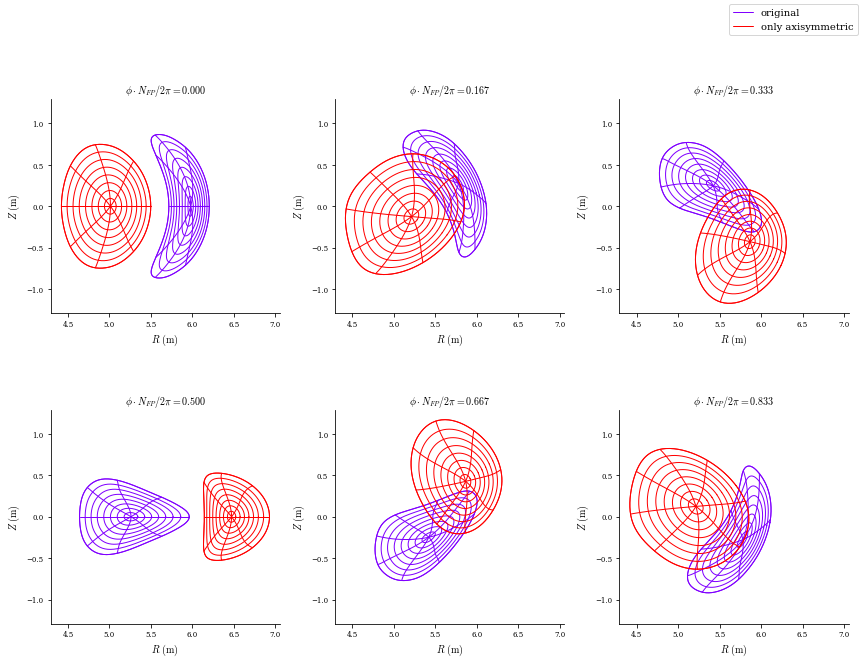

In [10]:
solve_step(eq_poincare, maxiter= 500, plot=True, ftol=0, gtol=0, xtol=0)